In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
from transformers import BertTokenizer, AutoAdapterModel, AdapterConfig
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load data
file_path = r"../datasets/"
train_file = r"train.csv"
test_file = r"test.csv"
subm_file = r"sample_submission.csv"

raw_train_data = pd.read_csv(file_path+train_file)
raw_test_data = pd.read_csv(file_path+test_file)

raw_train_data.shape

(7613, 5)

In [24]:
max_length = 0
count = 0
for i in range(0, raw_train_data.shape[0]):
    length = len(raw_train_data['text'].iloc[i])
    if length > max_length:
        max_length = length
    if length > 128:
        count += 1
count

2356

<Axes: >

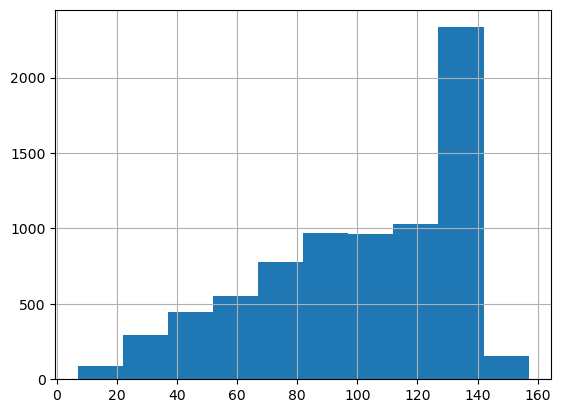

In [16]:
raw_train_data['text'].apply(lambda x: len(x)).hist()

In [3]:
# Tokenize the text using BERT's tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# Tokenize the text using BERT's tokenizer and ensure uniform sequence length
max_sequence_length = 128  # Adjust to an appropriate sequence length

raw_train_data['text'] = raw_train_data['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=max_sequence_length, truncation=True, padding='max_length'))
raw_test_data['text'] = raw_test_data['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=max_sequence_length, truncation=True, padding='max_length'))
raw_train_data['text'].head()

0    [101, 2256, 15616, 2024, 1996, 3114, 1997, 202...
1    [101, 3224, 2543, 2379, 2474, 6902, 3351, 2187...
2    [101, 2035, 3901, 2356, 2000, 1005, 7713, 1999...
3    [101, 2410, 1010, 2199, 2111, 4374, 1001, 3748...
4    [101, 2074, 2288, 2741, 2023, 6302, 2013, 1009...
Name: text, dtype: object

<Axes: >

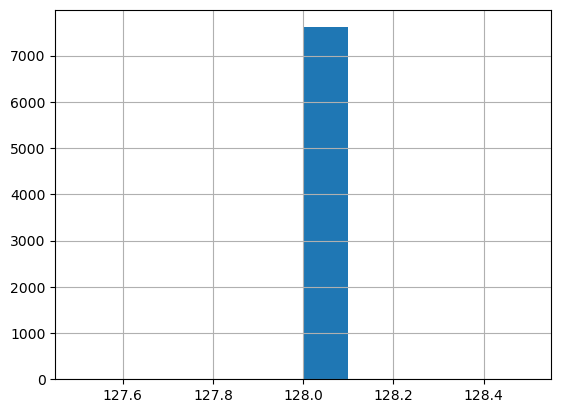

In [4]:
raw_train_data['text'].apply(lambda x: len(x)).hist()

In [4]:
# Split the data into train and train sets
# train : val : test = 70% : 15% : 15%
train_data, test_data, train_labels, test_labels = train_test_split(raw_train_data['text'], raw_train_data['target'], test_size=0.3, random_state=42)
val_data, test_data, val_labels, test_labels = train_test_split(raw_train_data['text'], raw_train_data['target'], test_size=0.5, random_state=42)

train_data = torch.LongTensor(train_data.tolist())
train_labels = torch.LongTensor(train_labels.tolist())
val_data = torch.LongTensor(val_data.tolist())
val_labels = torch.LongTensor(val_labels.tolist())
test_data = torch.LongTensor(raw_test_data['text'])

In [5]:
# Create PyTorch datasets and dataloaders
class DisasterDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

train_dataset = DisasterDataset(train_data, train_labels)
val_dataset = DisasterDataset(val_data, val_labels)
test_dataset = DisasterDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
val_loader = DataLoader(train_dataset, batch_size=32)

In [10]:
class DisasterClassifier(nn.Module):
    def __init__(self):
        super(DisasterClassifier, self).__init__()
        
        self.bert = AutoAdapterModel.from_pretrained('bert-base-uncased')
        for param in self.bert.parameters():
            param.requires_grad = False
        # Load pre-trained task adapter from Adapter Hub
        # This method call will also load a pre-trained classification head for the adapter task  
        self.adapter_config = AdapterConfig.load("pfeiffer")
        # self.adapter_config.label2id = {"real disaster": 1, "not a disaster": 0}
        self.bert.load_adapter("sentiment/sst-2@ukp", config=self.adapter_config) 
        # adapter_name = self.bert.load_adapter("sentiment/sst-2@ukp", config='pfeiffer')
        # # Activate the adapter we just loaded, so that it is used in every forward pass
        # self.bert.set_active_adapters(adapter_name)

        # check the reduction factor for "sentiment/sst-2@ukp": https://adapterhub.ml/adapters/ukp/bert-base-uncased_sentiment_sst-2_pfeiffer/
        # bert output dimension = 786/reduction factor
        self.adpter_reduction_factor = 16
        self.dimension_reduce_layer = nn.Linear(int(768/self.adpter_reduction_factor), 64)  # Reduce BERT's output dimension
        
        self.mlp = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(8, 2)  # 2 classes: real disaster or not
        )

    def forward(self, input_ids):
        outputs = self.bert(input_ids)
        pooled_output = outputs['last_hidden_state'].mean(dim=1)
        pooled_output = self.adaptive_layer(pooled_output)
        logits = self.mlp(pooled_output)
        return logits

# Initialize the model
model = DisasterClassifier()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertAdapterModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertAdapterModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertAdapterModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No valid map of labels in label2id. Falling back to default (num_labels=2). This may cause errors during loading!


In [13]:
# Set up the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epoches = 1
# Training loop
for epoch in range(epoches):
    model.train()
    for data, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Validation loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, labels in val_loader:
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Validation Accuracy: 56.75%


# Analyze

In [6]:
raw_train_data['text'].iloc[2]

"All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"

In [23]:
# check if the sample is balanced
n_p_sample = raw_train_data[raw_train_data['target'] == 1].shape[0]
n_sample = raw_train_data.shape[0]
perc_p_sample = n_p_sample/n_sample
perc_p_sample

0.4296597924602653

The training sample is kind of balanced

In [29]:
# number of different location
raw_train_data['location'].unique()

3342

array([[<Axes: title={'center': 'id'}>]], dtype=object)

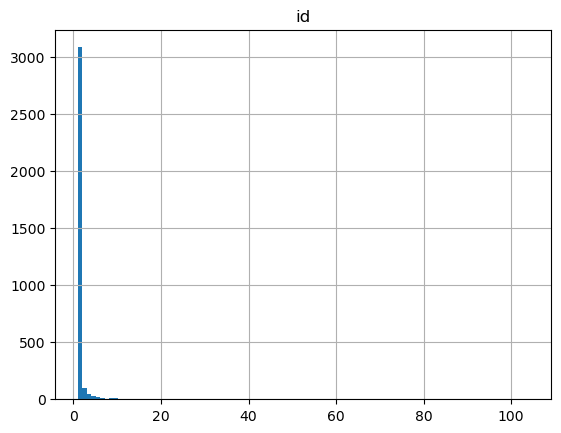

In [35]:
# number of disaster tweets in each location
raw_train_data[['location', 'id']].groupby('location').count().hist(bins=100)

In [36]:
# data cleaning 
raw_train_data["text"]

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

In [ ]:
X = raw_train_data["text"]
y = raw_train_data["target"]
# X represents your features, and y represents your labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)